In this notebook we will process statistics about the results of the pipeline 

In [72]:
# Imports
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import sqlite3
from dotenv import load_dotenv
import numpy as np
from utils.sql_query_parsers import get_sql_columns_dict

load_dotenv()

True

In [77]:
# Path to the result directory containing JSON files
res_path = "C:\\Users\\yousf\\Bureau\\ConvergenceAI\\CHESS_Impl\\run_results\\run_20240830_164648"

In [78]:
sds_path = "C:\\Users/yousf\Bureau\ConvergenceAI\CHESS_Impl\data\\subsampled_dev_set\\sub_sampled_bird_dev_set.json"
with open(sds_path, 'r') as file:
    sds = json.load(file)

## 1 / Distribution of Execution accuracy by difficulty levels 

In [79]:
# Initialize data structure to hold results
accuracy_results = defaultdict(lambda: {'total': 0, 'correct': 0})

# Iterate over all JSON files in the directory
index = 0
for json_file in os.listdir(res_path):
    if json_file.endswith('.json'):
        # Load the JSON data
        with open(os.path.join(res_path, json_file), 'r') as f:
            data = json.load(f)

        # Get the difficulty level
        difficulty_level = sds[index]["difficulty"]

        # Get the execution result
        exec_res = data["evaluation"]["revision"]["exec_res"]

        # Count the total number of tasks for this difficulty level
        accuracy_results[difficulty_level]['total'] += 1

        # Check if the execution result is correct
        if exec_res == 1:
            accuracy_results[difficulty_level]['correct'] += 1
    index += 1

# Prepare lists for each category to fill the table
difficulty_levels = ['simple', 'moderate', 'challenging', 'All']
total_examples = []
accuracies = []

# Calculate accuracy for each difficulty level
for difficulty in difficulty_levels[:-1]:  # Skip 'All' for now
    total = accuracy_results[difficulty]['total']
    correct = accuracy_results[difficulty]['correct']
    accuracy = correct / total if total > 0 else 0
    total_examples.append(total)
    accuracies.append(accuracy)

# Calculate for 'All examples'
total_all = sum(total_examples)
correct_all = sum(accuracy_results[difficulty]['correct'] for difficulty in difficulty_levels[:-1])
accuracy_all = correct_all / total_all if total_all > 0 else 0
total_examples.append(total_all)
accuracies.append(accuracy_all)

# Create the DataFrame for the table
df = pd.DataFrame({
    'Difficulty Level': difficulty_levels,
    'Number of Examples': total_examples,
    'Execution Accuracy': [round(acc, 3) * 100 for acc in accuracies]  # Round to 3 decimal places for display
})

# Display the table
df

,Difficulty Level,Number of Examples,Execution Accuracy
0,simple,81,58.0
1,moderate,54,63.0
2,challenging,12,50.0
3,All,147,59.2


## 2/Total and Average Cost & Cost Distribution Diagram:

Total Cost: 11.117
Average Cost: 0.076
Median Cost: 0.073


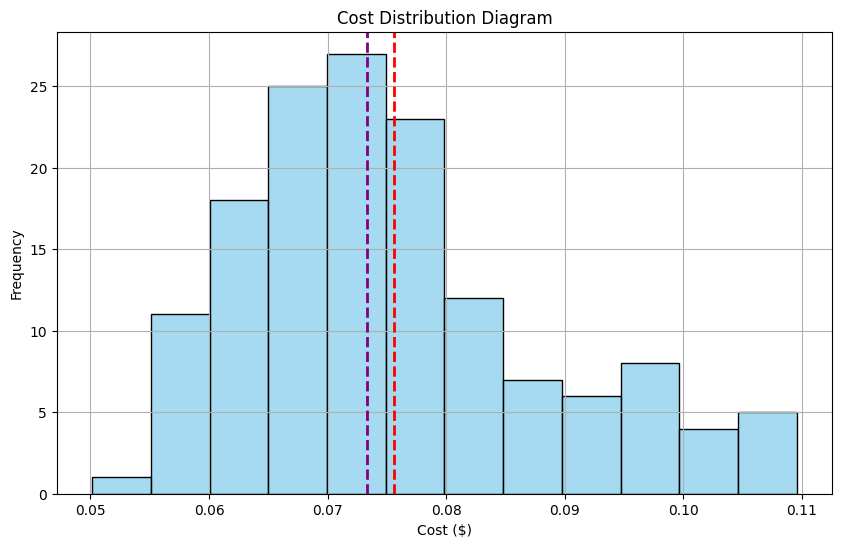

In [38]:
# Initialize total cost and list for all costs
total_cost = 0
all_costs = []

# Iterate over all JSON files in the directory
for json_file in os.listdir(res_path):
    if json_file.endswith('.json'):
        # Load the JSON data
        with open(os.path.join(res_path, json_file), 'r') as f:
            data = json.load(f)

        # Get the cost from the JSON data (assuming cost is a value in the structure)
        cost = data["cost"]

        # Accumulate the total cost and collect costs
        total_cost += cost
        all_costs.append(cost)

# Calculate the average cost
average_cost = total_cost / len(all_costs) if all_costs else 0
#Calculate the median cost
median_cost = statistics.median(all_costs)
# Print the total and average cost
print(f"Total Cost: {total_cost:.3f}")
print(f"Average Cost: {average_cost:.3f}")
print(f"Median Cost: {median_cost:.3f}")
# Generate Cost Distribution Histogram
plt.figure(figsize=(10, 6))
sns.histplot(all_costs, bins=12, color='skyblue')
plt.axvline(average_cost, color='red', linestyle='--', linewidth=2, label=f'Average cost: ${average_cost:.3f}')
plt.axvline(median_cost, color='purple', linestyle='--', linewidth=2, label=f'Median cost: ${median_cost:.3f}')

plt.title('Cost Distribution Diagram')
plt.xlabel('Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 3/Total and Average Latency & Latency Distribution Diagram:

Total Latency:  18620.408
Average Latency: 126.669
Median Latency:  105.644


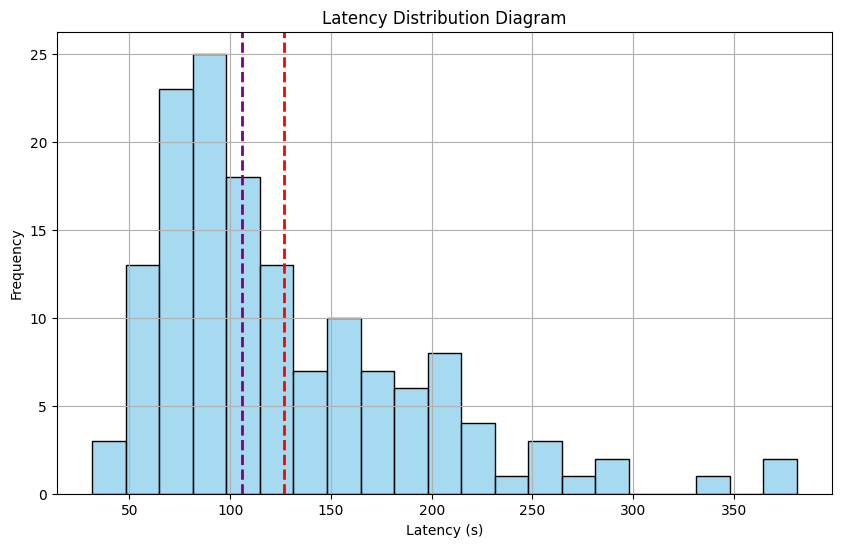

In [37]:


# Initialize total cost and list for all costs
total_latency = 0
all_latencies = []

# Iterate over all JSON files in the directory
for json_file in os.listdir(res_path):
    if json_file.endswith('.json'):
        # Load the JSON data
        with open(os.path.join(res_path, json_file), 'r') as f:
            data = json.load(f)

        # Get the cost from the JSON data (assuming cost is a value in the structure)
        latency = data["latency"]

        # Accumulate the total latency and collect latencies
        total_latency += latency
        all_latencies.append(latency)

# Calculate the average latency
average_latency = total_latency / len(all_latencies) if all_latencies else 0
# Calculate the median 
median_latency = statistics.median(all_latencies)

# Print the total and average latency
print(f"Total Latency: {total_latency: .3f}")
print(f"Average Latency: {average_latency:.3f}")
print(f"Median Latency: {median_latency: .3f}")

# Generate Latency Distribution Histogram
plt.figure(figsize=(10, 6))
sns.histplot(all_latencies, bins=21, color='skyblue')
plt.axvline(average_latency, color='red', linestyle='--', linewidth=2, label=f'Average latency: ${average_latency:.3f}')
plt.axvline(median_latency, color='purple', linestyle='--', linewidth=2, label=f'Median latency: ${median_latency:.3f}')

plt.title('Latency Distribution Diagram')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 4/ 4. Average Cost and Latency for Each Pipeline Module:

In [43]:
# Initialize data structure to hold module costs and latencies
module_stats = {}

# Iterate over all JSON files in the directory
for json_file in os.listdir(res_path):
    if json_file.endswith('.json'):
        # Load the JSON data
        with open(os.path.join(res_path, json_file), 'r') as f:
            data = json.load(f)

        # Get module costs and latencies
        module_costs = data["module_costs"]
        module_latencies = data["module_latencies"]

        # Accumulate costs and latencies for each module
        for module, cost in module_costs.items():
            if module not in module_stats:
                module_stats[module] = {'total_cost': 0, 'total_latency': 0, 'count': 0}
            module_stats[module]['total_cost'] += cost
            module_stats[module]['total_latency'] += module_latencies.get(module, 0)  # Default to 0 if missing
            module_stats[module]['count'] += 1

# Prepare data for table presentation
module_names = []
average_costs = []
average_latencies = []
total_costs = []
total_latencies = []

# Calculate total cost and latency for percentage breakdown
total_cost = sum(stats['total_cost'] for stats in module_stats.values())
total_latency = sum(stats['total_latency'] for stats in module_stats.values())

for module, stats in module_stats.items():
    avg_cost = stats['total_cost'] / stats['count']
    avg_latency = stats['total_latency'] / stats['count']
    module_names.append(module)
    total_costs.append(stats['total_cost'])
    total_latencies.append(stats['total_latency'])
    average_costs.append(avg_cost)
    average_latencies.append(avg_latency)

# Create a pandas DataFrame to show the results
df = pd.DataFrame({
    'Module': module_names,
    'Average Cost ($)': average_costs,
    'Average Latency (ms)': average_latencies
})

# Display the table
df


,Module,Average Cost ($),Average Latency (ms)
0,keyword_extraction,0.000122,1.106783
1,entity_retrieval,0.000074,79.676951
2,context_retrieval,0.000000,8.816522
3,table_selection,0.019616,9.501653
4,column_selection,0.014896,7.772628
5,candidate_generation,0.016010,10.176176
6,revision,0.024910,9.412662
7,evaluation,0.000000,0.206068


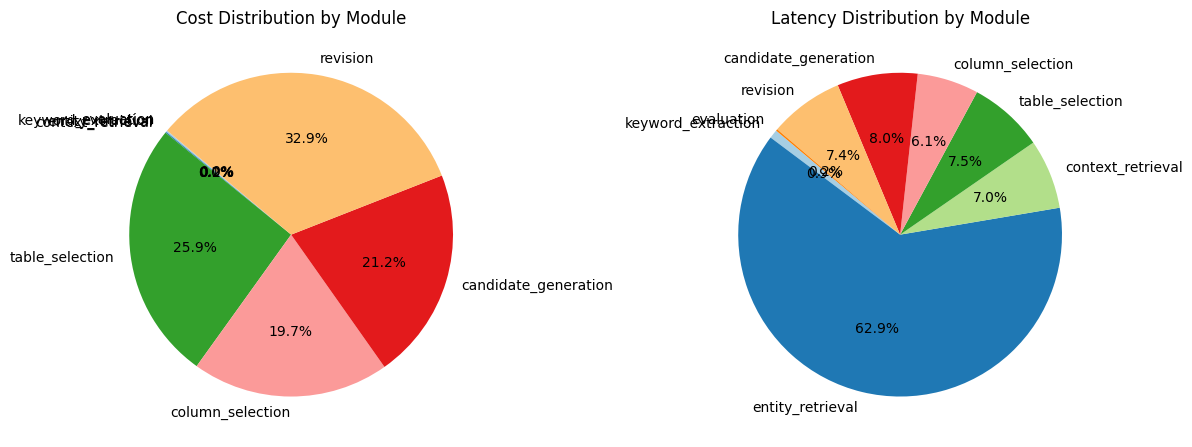

In [44]:
# Pie chart for cost distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Create subplots for side-by-side pie charts
plt.pie(total_costs, labels=module_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Cost Distribution by Module')

# Pie chart for latency distribution
plt.subplot(1, 2, 2)
plt.pie(total_latencies, labels=module_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Latency Distribution by Module')

# Add a vertical space between the plots
plt.tight_layout()

# Display the pie charts
plt.show()

## 5/ Average Cost and Latency Grouped by Database and Aggregated with Database Size:

In [55]:
# Function to extract database size, number of tables, and number of columns
def get_database_info(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Get the size of the database file
    db_size = os.path.getsize(db_path)

    # Count the number of tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    num_tables = len(tables)

    # Count the number of columns across all tables
    num_columns = 0
    for table in tables:
        cursor.execute(f"PRAGMA table_info(`{table[0]}`);")
        columns = cursor.fetchall()
        num_columns += len(columns)

    conn.close()
    return db_size, num_tables, num_columns

In [56]:
# Initialize data structure to hold results grouped by database
database_stats = {}

# Path to the folder containing the SQLite database files
index = 0
# Iterate over all JSON files in the result directory
for json_file in os.listdir(res_path):
    if json_file.endswith('.json'):
        # Load the JSON data
        with open(os.path.join(res_path, json_file), 'r') as f:
            data = json.load(f)

        # Extract database name
        database_name = sds[index]["db_id"]
        db_path = os.path.join(os.getenv("DB_ROOT_PATH") + f"/{database_name}", f"{database_name}.sqlite")
        # Extract task's cost and latency
        total_cost = data["cost"]
        total_latency = data["latency"]

        # Ensure that database stats are initialized
        if database_name not in database_stats:
            # Get database size and structure
            db_size, num_tables, num_columns = get_database_info(db_path)
            database_stats[database_name] = {
                'total_cost': 0,
                'total_latency': 0,
                'count': 0,
                'db_size': db_size,
                'num_tables': num_tables,
                'num_columns': num_columns
            }

        # Accumulate costs and latencies for this database

        database_stats[database_name]['total_cost'] += total_cost
        database_stats[database_name]['total_latency'] += total_latency
        database_stats[database_name]['count'] += 1
    index += 1

# Prepare data for table presentation
database_names = []
average_costs = []
average_latencies = []
db_sizes = []
num_tables_list = []
num_columns_list = []

# Calculate averages for each database
for db_name, stats in database_stats.items():
    avg_cost = stats['total_cost'] / stats['count']
    avg_latency = stats['total_latency'] / stats['count']

    database_names.append(db_name)
    average_costs.append(avg_cost)
    average_latencies.append(avg_latency)
    db_sizes.append(stats['db_size'])
    num_tables_list.append(stats['num_tables'])
    num_columns_list.append(stats['num_columns'])

# Create a pandas DataFrame to show the results
df = pd.DataFrame({
    'Database': database_names,
    'Avg Cost ($)': average_costs,
    'Avg Latency (ms)': average_latencies,
    'DB Size (Bytes)': db_sizes,
    'Number of Tables': num_tables_list,
    'Number of Columns': num_columns_list
})

# Display the table
df


,Database,Avg Cost ($),Avg Latency (ms),DB Size (Bytes),Number of Tables,Number of Columns
0,california_schools,0.094049,124.553422,11116544,3,89
1,financial,0.088866,91.063124,71294976,8,55
2,toxicology,0.073132,109.482342,2678784,4,11
3,card_games,0.064508,83.440472,261820416,7,117
4,codebase_community,0.064296,95.169898,481419264,8,71
5,superhero,0.078273,135.819639,237568,10,31
6,formula_1,0.082999,186.459512,22360064,14,96
7,european_football_2,0.075871,109.077689,597754880,8,201
8,thrombosis_prediction,0.071798,174.673124,7327744,3,64
9,student_club,0.081113,148.323691,2641920,8,48


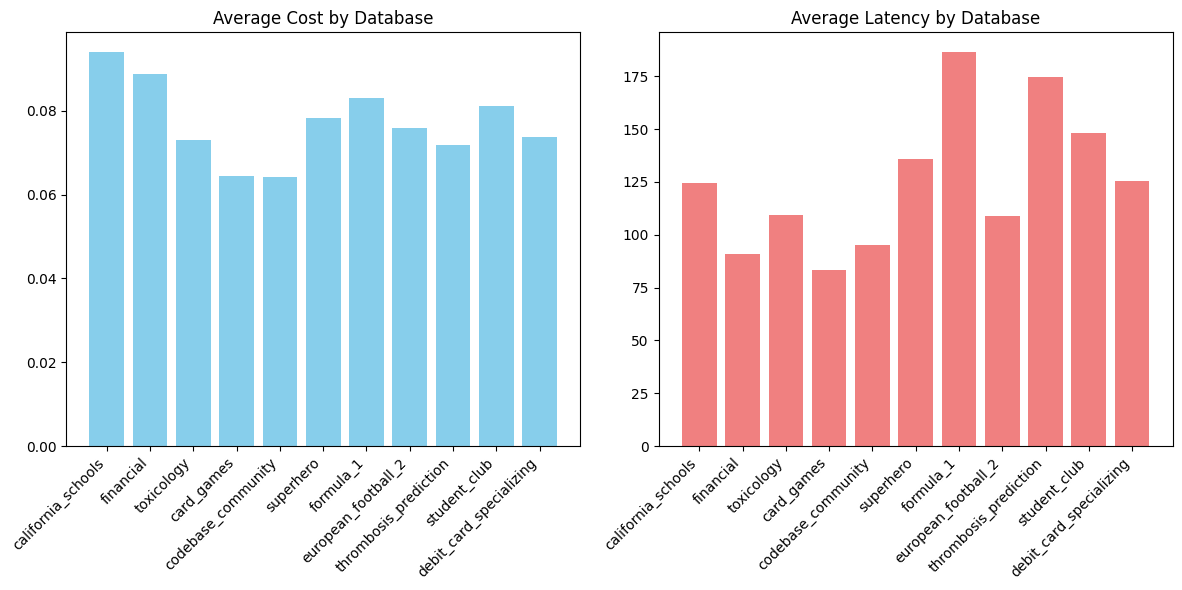

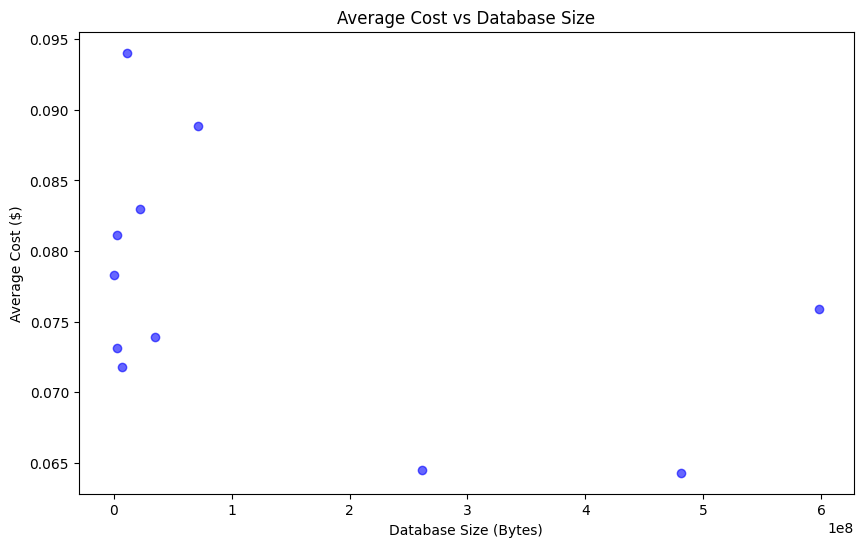

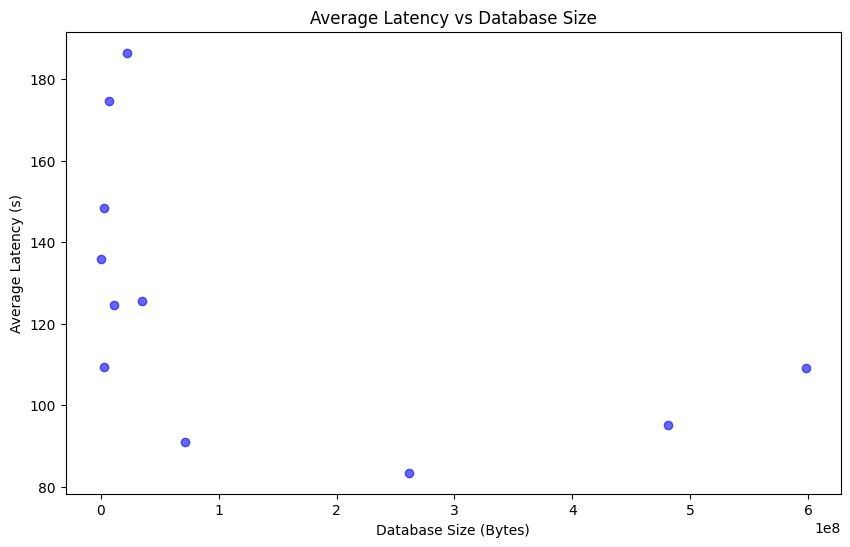

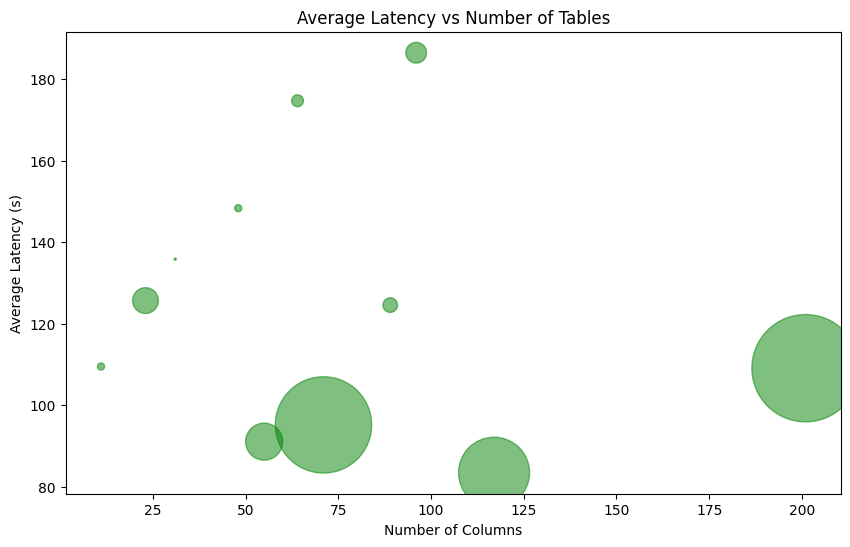

In [65]:

# Visualization Proposals
# 1. Bar Chart for Avg Cost and Latency by Database
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(database_names, average_costs, color='skyblue')
plt.title('Average Cost by Database')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(database_names, average_latencies, color='lightcoral')
plt.title('Average Latency by Database')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 2. Scatter Plot to show Avg Cost vs DB Size
plt.figure(figsize=(10, 6))
plt.scatter(db_sizes, average_costs, color='blue', alpha=0.6)
plt.title('Average Cost vs Database Size')
plt.xlabel('Database Size (Bytes)')
plt.ylabel('Average Cost ($)')
plt.show()

# 3. Scatter Plot to show Avg Latency vs DB Size
plt.figure(figsize=(10, 6))
plt.scatter(db_sizes, average_latencies, color='blue', alpha=0.6)
plt.title('Average Latency vs Database Size')
plt.xlabel('Database Size (Bytes)')
plt.ylabel('Average Latency (s)')
plt.show()

# 3. Bubble Chart for Avg Latency vs Number of Tables/Columns
plt.figure(figsize=(10, 6))
plt.scatter(num_columns_list, average_latencies, s=[num / 100000 for num in db_sizes], alpha=0.6, color='green')
plt.title('Average Latency vs Number of Tables')
plt.xlabel('Number of Columns')
plt.ylabel('Average Latency (s)')
plt.show()

## 6/ Recall and Precision for Predicted Tables and Columns:

In [70]:
# Function to calculate precision, recall, and F1-score
def calculate_precision_recall_f1(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1


# Function to evaluate the schema prediction against the ground truth
def evaluate_schema(ground_truth, predicted):
    """
    ground_truth and predicted are dictionaries with tables as keys and lists of columns as values.
    """
    # Transform all table and column names to lowercase
    ground_truth = {table.lower(): [col.lower() for col in columns] for table, columns in ground_truth.items()}
    predicted = {table.lower(): [col.lower() for col in columns] for table, columns in predicted.items()}

    # Evaluate tables
    gt_tables = set(ground_truth.keys())
    pred_tables = set(predicted.keys())

    tp_tables = len(gt_tables.intersection(pred_tables))
    fp_tables = len(pred_tables.difference(gt_tables))
    fn_tables = len(gt_tables.difference(pred_tables))

    table_precision, table_recall, table_f1 = calculate_precision_recall_f1(tp_tables, fp_tables, fn_tables)

    # Evaluate columns
    tp_columns = 0
    fp_columns = 0
    fn_columns = 0

    for table in gt_tables:
        gt_columns = set(ground_truth[table])
        pred_columns = set(predicted.get(table, []))

        tp_columns += len(gt_columns.intersection(pred_columns))
        fp_columns += len(pred_columns.difference(gt_columns))
        fn_columns += len(gt_columns.difference(pred_columns))

    column_precision, column_recall, column_f1 = calculate_precision_recall_f1(tp_columns, fp_columns, fn_columns)

    return {
        "table_metrics": {
            "precision": table_precision,
            "recall": table_recall,
            "f1": table_f1
        },
        "column_metrics": {
            "precision": column_precision,
            "recall": column_recall,
            "f1": column_f1
        }
    }


# Function to aggregate metrics across multiple tasks
def aggregate_metrics(evals):
    table_precision = np.mean([evaluation['table_metrics']['precision'] for evaluation in evals])

    table_recall = np.mean([evaluation['table_metrics']['recall'] for evaluation in evals])
    table_f1 = np.mean([evaluation['table_metrics']['f1'] for evaluation in evals])

    column_precision = np.mean([evaluation['column_metrics']['precision'] for evaluation in evals])
    column_recall = np.mean([evaluation['column_metrics']['recall'] for evaluation in evals])
    column_f1 = np.mean([evaluation['column_metrics']['f1'] for evaluation in evals])

    return {
        "table_metrics": {
            "precision": table_precision,
            "recall": table_recall,
            "f1": table_f1
        },
        "column_metrics": {
            "precision": column_precision,
            "recall": column_recall,
            "f1": column_f1
        }
    }


# Plotting function to visualize precision, recall, and F1-score
def plot_metrics(metrics):
    categories = ['Tables', 'Columns']

    precision_values = [
        metrics['table_metrics']['precision'],
        metrics['column_metrics']['precision']
    ]

    recall_values = [
        metrics['table_metrics']['recall'],
        metrics['column_metrics']['recall']
    ]

    f1_values = [
        metrics['table_metrics']['f1'],
        metrics['column_metrics']['f1']
    ]

    x = np.arange(len(categories))
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, precision_values, width, label='Precision')
    rects2 = ax.bar(x, recall_values, width, label='Recall')
    rects3 = ax.bar(x + width, f1_values, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title('Average Precision, Recall, and F1 Score for Tables and Columns')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.ylim(0, 1)  # Set y-axis range from 0 to 1
    plt.show()


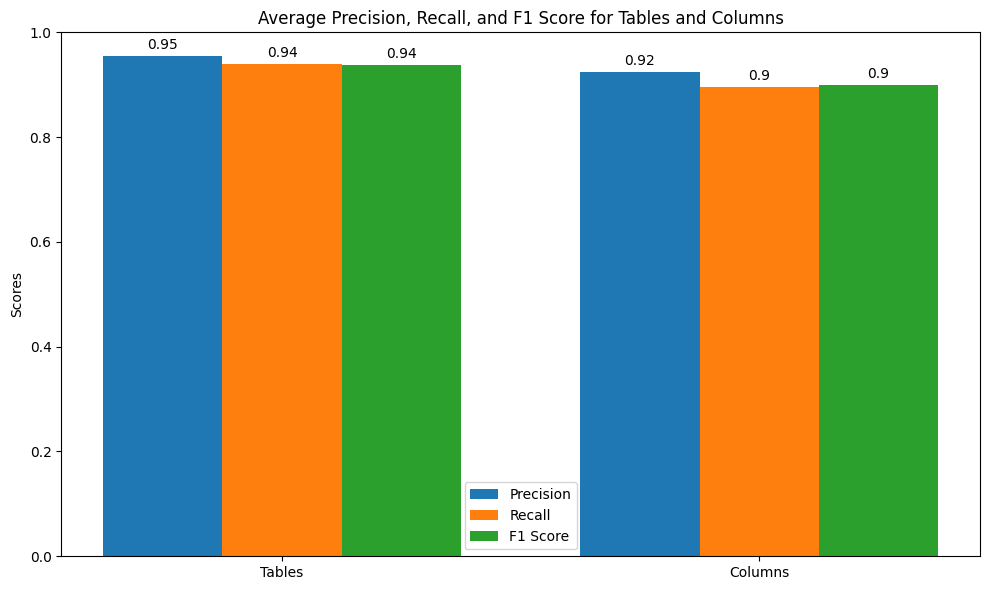

In [71]:

evals = []
index = 0
# Iterate over all JSON files in the result directory
for json_file in os.listdir(res_path):
    if json_file.endswith('.json'):
        # Load the JSON data
        with open(os.path.join(res_path, json_file), 'r') as f:
            data = json.load(f)

        # Extract the predicted schema
        pred_schema = data["column_selection"]["selected_schema"]
        # get the ground truth schema
        db_path = os.getenv("DB_ROOT_PATH") + f"/{sds[index]['db_id']}/{sds[index]['db_id']}.sqlite"
        gt_schema = get_sql_columns_dict(db_path, data["evaluation"]["GOLD_SQL"])
        evaluation = evaluate_schema(gt_schema, pred_schema)
        evals.append(evaluation)
# Aggregate metrics across all tasks
aggregated_metrics = aggregate_metrics(evals)

# Plot the metrics
plot_metrics(aggregated_metrics)
    
    